## Responses Analysis

### Looking into Task 1

In [6]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install matplotlib

  Using cached contourpy-1.3.3-cp311-cp311-macosx_10_9_x86_64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.9-cp311-cp311-macosx_10_9_x86_64.whl.metadata (6.3 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 3.4 MB/s  0:00:02m0:00:0100:010m
Using cached contourpy-1.3.3-cp311-cp311-macosx_10_9_x86_64.whl (288 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 7.2 MB/s  0:00:00 eta 0:00:01
Using cached kiwisolver-1.4.9-cp311-cp311-macosx_10_9_x86_64.whl (66 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 7.1 MB/s  0:00:00 eta 0:00:01
Using cached pyparsing-3.2.5-py3-none-any.whl (113 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [matplotlib]7 [matplotlib]
Note: you may need to restart the kernel to use updated packages.


In [29]:
pip install scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.5/23.5 MB 9.4 MB/s  0:00:02 eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [45]:
pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


Found 5 task files total.



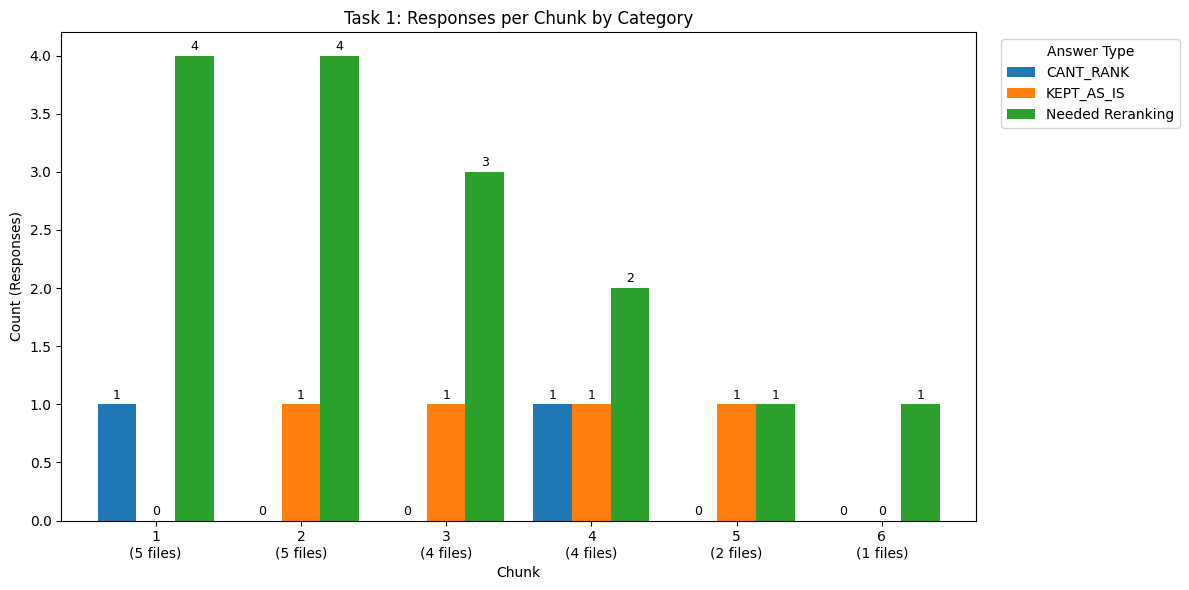


Number of files contributing to each chunk (per-file presence):
   n_files
1        5
2        5
3        4
4        4
5        2
6        1


In [56]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

# --- Path to your responses folder ---
responses_dir = "/Users/hannahgonzalez/Documents/JHU/RankerWebsite/ranking-annotation-UI/ranker-main/server/responses"

# --- Collect all task_1 files ---
task_files = [
    os.path.join(responses_dir, f)
    for f in os.listdir(responses_dir)
    if f.endswith("task_1.json")
]
print(f"Found {len(task_files)} task files total.\n")

# --- Read data and track chunks per file ---
records = []
chunks_by_file = {}  # file_basename -> set(chunks)

for file_path in task_files:
    basename = os.path.basename(file_path)
    with open(file_path, "r") as f:
        try:
            data = json.load(f)
        except Exception as e:
            print(f"⚠️ Failed to read {basename}: {e}")
            data = []
    seen_chunks = set()
    for entry in data:
        try:
            chunk = int(entry.get("chunk"))
        except Exception:
            continue
        answer = entry.get("answer")
        if answer == "KEPT_AS_IS":
            category = "KEPT_AS_IS"
        elif answer == "CANT_RANK":
            category = "CANT_RANK"
        elif isinstance(answer, list):
            category = "Needed Reranking"
        else:
            category = "OTHER"
        records.append({"file": basename, "chunk": chunk, "category": category})
        seen_chunks.add(chunk)
    chunks_by_file[basename] = seen_chunks

# --- Count how many files include each chunk ---
all_chunks = sorted({r["chunk"] for r in records})
files_per_chunk = {c: 0 for c in all_chunks}
for fname, chunkset in chunks_by_file.items():
    for c in chunkset:
        if c in files_per_chunk:
            files_per_chunk[c] += 1
files_per_chunk = pd.Series(files_per_chunk).sort_index()

# --- Build counts per chunk/category ---
df = pd.DataFrame(records)
counts = df.groupby(["chunk", "category"]).size().unstack(fill_value=0)
counts = counts.reindex(all_chunks, fill_value=0)

# --- Plot grouped bars ---
fig, ax = plt.subplots(figsize=(12, 6))
counts.plot(kind="bar", ax=ax, width=0.8)

# --- Title & axis labels ---
ax.set_title("Task 1: Responses per Chunk by Category")
ax.set_xlabel("Chunk")
ax.set_ylabel("Count (Responses)")

# --- X-axis labels include number of files ---
xticklabels = [f"{chunk}\n({files_per_chunk.get(chunk, 0)} files)" for chunk in counts.index]
ax.set_xticklabels(xticklabels, rotation=0)

# --- Add numeric count labels to each bar ---
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=9, padding=2)

# --- Legend and layout tweaks ---
ax.legend(title="Answer Type", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

# --- Print summary table for reference ---
print("\nNumber of files contributing to each chunk (per-file presence):")
print(files_per_chunk.to_frame(name="n_files"))


In [57]:
import os
import json
from scipy.stats import spearmanr
import pandas as pd

# --- Paths ---
responses_dir = "/Users/hannahgonzalez/Documents/JHU/RankerWebsite/ranking-annotation-UI/ranker-main/server/responses"
payloads_dir = "/Users/hannahgonzalez/Documents/JHU/RankerWebsite/ranking-annotation-UI/ranker-main/src/payloads"

# --- Find all task_1 response files ---
task1_files = [f for f in os.listdir(responses_dir) if f.endswith("task_1.json")]
print(f"Found {len(task1_files)} task_1 response files.\n")

all_records = []

for file_name in task1_files:
    annotator = file_name.replace("_responses_task_1.json", "")
    response_file = os.path.join(responses_dir, file_name)
    payload_file = os.path.join(payloads_dir, f"{annotator}-payload.json")  # assuming this naming format

    if not os.path.exists(payload_file):
        print(f"⚠️ Ground truth payload not found for {annotator}, skipping.")
        continue

    # --- Load response and ground truth ---
    with open(response_file, "r") as f:
        responses = json.load(f)
    with open(payload_file, "r") as f:
        ground_data = json.load(f)

    for entry in responses:
        paper_id = entry["paperId"]
        chunk = entry["chunk"]
        answer = entry["answer"]

        # Get ground-truth candidates for this paper/chunk
        gt_entry = next((p for p in ground_data if p["paperId"] == paper_id and str(p.get("chunk")) == str(chunk)), None)
        if not gt_entry:
            continue
        gt_answer = [c["paperId"] for c in gt_entry["candidates"]]

        if answer == "KEPT_AS_IS":
            rho = 1.0
            status = "KEPT_AS_IS"
        elif answer == "CANT_RANK":
            rho = None
            status = "CANT_RANK"
        elif isinstance(answer, list):
            common_ids = [pid for pid in answer if pid in gt_answer]
            if len(common_ids) < 2:
                rho = None
            else:
                annot_ranks = [answer.index(pid) + 1 for pid in common_ids]
                gt_ranks = [gt_answer.index(pid) + 1 for pid in common_ids]
                rho, _ = spearmanr(annot_ranks, gt_ranks)
                rho = round(rho, 3)
            status = "RERANKED"
        else:
            rho = None
            status = "UNKNOWN"

        all_records.append({
            "annotator": annotator,
            "paperId": paper_id,
            "chunk": chunk,
            "status": status,
            "spearman_r": rho
        })

# --- Build DataFrame ---
df = pd.DataFrame(all_records)

# --- Group by annotator + paperId ---
grouped = df.groupby(["annotator","paperId"]).agg(
    chunks=('chunk', list),
    statuses=('status', list),
    spearman_r_per_chunk=('spearman_r', list),
    mean_spearman=('spearman_r', lambda x: round(pd.Series(x).dropna().mean(), 3))
).reset_index()

display(grouped)


Found 5 task_1 response files.



,annotator,paperId,chunks,statuses,spearman_r_per_chunk,mean_spearman
0,austen,c6fa25f723a1a842b8452bc04d154e44186d05c1,"[1, 2, 3, 4, 5, 6]","[RERANKED, RERANKED, RERANKED, RERANKED, RERAN...","[0.143, 0.214, -0.738, 0.619, 0.548, -0.5]",0.048
1,hannah,7b489c47ebca2c1df0e611e76b9649f69e4fce29,"[1, 2]","[RERANKED, KEPT_AS_IS]","[0.857, 1.0]",0.928
2,jackc,88833319309da6d8a8d7ab0318f72f6d6f383b30,"[1, 2, 3, 4, 5]","[CANT_RANK, RERANKED, RERANKED, CANT_RANK, KEP...","[nan, -0.5, 0.786, nan, 1.0]",0.429
3,jiefu,19f59c14b3d79e3203c696128a135d33eb35e468,"[1, 2, 3, 4]","[RERANKED, RERANKED, RERANKED, RERANKED]","[0.452, 0.548, 0.429, 0.4]",0.457
4,rohan,c43cc65148bf7221ff035c75621b663371fe8250,"[1, 2, 3, 4]","[RERANKED, RERANKED, KEPT_AS_IS, KEPT_AS_IS]","[0.381, 0.286, 1.0, 1.0]",0.667


/var/folders/sg/ycytj2314dn0nb9vf68d7d3m0000gn/T/ipykernel_99144/3702462272.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(


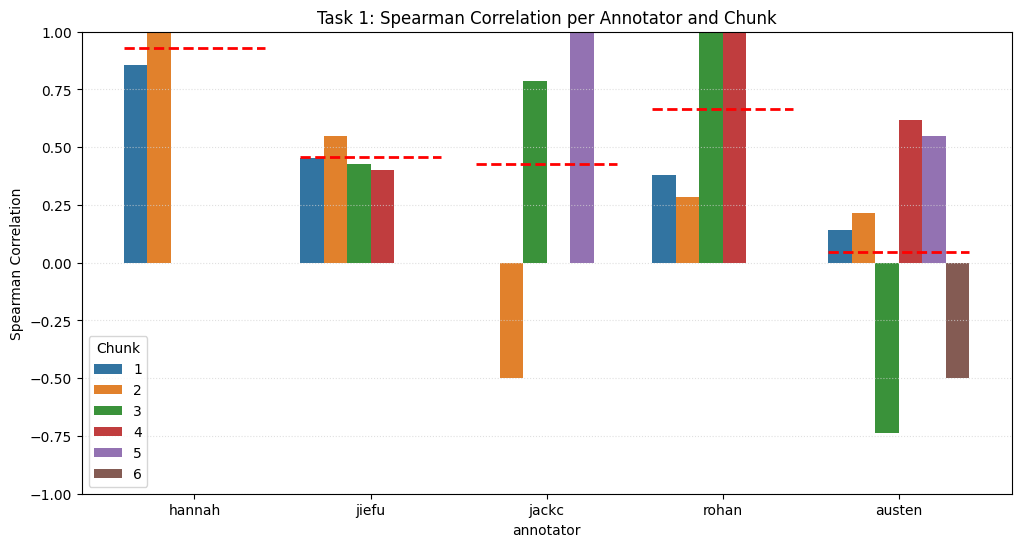

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Prepare a copy
plot_df = df.copy()

# Convert spearman_r to float, non-numeric becomes NaN
plot_df["spearman_r_float"] = plot_df["spearman_r"].apply(lambda x: float(x) if str(x).replace('.','',1).replace('-','',1).isdigit() else np.nan)

plt.figure(figsize=(12,6))

# Barplot per chunk, disable confidence interval to show negative values correctly
ax = sns.barplot(
    data=plot_df,
    x="annotator",
    y="spearman_r_float",
    hue="chunk",
    palette="tab10",
    ci=None
)

# Light gray horizontal gridlines
ax.grid(axis='y', linestyle=':', color='lightgray', linewidth=0.8, alpha=0.7)

# Compute mean Spearman per annotator (ignores NaN)
mean_spearman = plot_df.groupby("annotator")["spearman_r_float"].mean()

# Map annotator names to x positions
xticks = ax.get_xticks()
annotators = plot_df["annotator"].unique()
annotator_pos = {a: xticks[i] for i, a in enumerate(annotators)}

# Draw mean lines at correct x positions
for annotator, mean_val in mean_spearman.items():
    x = annotator_pos[annotator]
    ax.hlines(mean_val, x - 0.4, x + 0.4, colors='red', linestyles='--', linewidth=2)

# Keep full y-axis range to show negative values
ax.set_ylim(-1, 1)
ax.set_ylabel("Spearman Correlation")
ax.set_title("Task 1: Spearman Correlation per Annotator and Chunk")
ax.legend(title="Chunk")
plt.show()


### Looking into Task 2

In [42]:
import os
import json
import pandas as pd

# --- Paths ---
responses_dir = "/Users/hannahgonzalez/Documents/JHU/RankerWebsite/ranking-annotation-UI/ranker-main/server/responses"
payloads_dir = "/Users/hannahgonzalez/Documents/JHU/RankerWebsite/ranking-annotation-UI/ranker-main/src/payloads"

# --- Find all task_2 response files ---
task2_files = [
    os.path.join(responses_dir, f)
    for f in os.listdir(responses_dir)
    if f.endswith("task_2.json")
]

print(f"Found {len(task2_files)} task_2 response files.\n")

records = []

for file_path in task2_files:
    # Infer annotator name
    base = os.path.basename(file_path)
    if not base.endswith("_responses_task_2.json"):
        continue
    annotator = base.replace("_responses_task_2.json", "")

    # Load corresponding ground truth file
    payload_file = os.path.join(payloads_dir, f"{annotator}-payload-task-2.json")
    if not os.path.exists(payload_file):
        print(f"⚠️ Ground truth payload not found for {annotator}, skipping.")
        continue

    with open(payload_file, "r") as f:
        ground_data = json.load(f)

    # Build lookup: paperId → {candidate_id: rank}
    ground_lookup = {
        entry["paperId"]: {c["paperId"]: int(c["rank"]) for c in entry["candidates"]}
        for entry in ground_data
    }

    # Load annotator responses
    with open(file_path, "r") as f:
        responses = json.load(f)

    for entry in responses:
        paper_id = entry["paperId"]
        answers = entry["answer"]
        if not isinstance(answers, list):
            continue  # skip KEPT_AS_IS etc.

        ground_ranks_dict = ground_lookup.get(paper_id, {})
        # Build list of tuples: (ground_rank, paper_id)
        ranks_with_ids = [(ground_ranks_dict.get(a), a) for a in answers if ground_ranks_dict.get(a) is not None]
        # Sort by ground truth rank
        ranks_with_ids_sorted = sorted(ranks_with_ids, key=lambda x: x[0])

        # Separate back into sorted lists
        sorted_paper_ids = [a for _, a in ranks_with_ids_sorted]
        sorted_ground_ranks = [r for r, _ in ranks_with_ids_sorted]

        records.append({
            "annotator": annotator,
            "paperId": paper_id,
            "answers_sorted_by_ground": sorted_paper_ids,
            "ground_truth_ranks_sorted": sorted_ground_ranks
        })

# --- Build DataFrame ---
df = pd.DataFrame(records)
display(df)


Found 5 task_2 response files.



,annotator,paperId,answers_sorted_by_ground,ground_truth_ranks_sorted
0,austen,c6fa25f723a1a842b8452bc04d154e44186d05c1,"[6a8dbea5e40831bd6e987c03b76487f45ac49599, 23d...","[1, 2, 6, 16, 24, 33, 39]"
1,rohan,c43cc65148bf7221ff035c75621b663371fe8250,"[590432f953b6ce1b4b36bf66a2ac65eeee567515, c74...","[2, 3, 4, 10, 13, 24]"
2,jiefu,19f59c14b3d79e3203c696128a135d33eb35e468,"[025f852b227766c3a5dc914ded6f6c0ae137c617, e78...","[1, 2, 3, 6, 10]"
3,jackc,88833319309da6d8a8d7ab0318f72f6d6f383b30,"[28e3a79454bd09a2021a91e42b4b180477796445, 1b6...","[1, 14, 19, 34]"
4,hannah,7b489c47ebca2c1df0e611e76b9649f69e4fce29,"[90abbc2cf38462b954ae1b772fac9532e2ccd8b0, 1bc...","[1, 2, 5]"


In [3]:
!pip install matplotlib
!pip install scipy

  Using cached scipy-1.16.3-cp311-cp311-macosx_14_0_x86_64.whl.metadata (62 kB)
Using cached scipy-1.16.3-cp311-cp311-macosx_14_0_x86_64.whl (23.5 MB)


Found 3 task_2 response files.


=== Category Counts per Annotator ===


,annotator,most_impactful_count,medium_impactful_count,lowest_impactful_count
0,rohan,5,6,14
1,jackc,2,6,26
2,hannah,2,2,8



=== Spearman Rank Correlation per Annotator ===


,annotator,mean_spearman
0,rohan,0.795385
1,jackc,0.845989
2,hannah,0.993007



=== Detailed Comparison DataFrame ===


,annotator,paperId,answers,labels,answers_sorted_by_ground,ground_truth_ranks_sorted
0,rohan,c43cc65148bf7221ff035c75621b663371fe8250,"[60b8ad6177230ad5402af409a6edb5af441baeb4, 9e3...","[most-impactful, most-impactful, most-impactfu...","[60b8ad6177230ad5402af409a6edb5af441baeb4, 590...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
1,jackc,88833319309da6d8a8d7ab0318f72f6d6f383b30,"[28e3a79454bd09a2021a91e42b4b180477796445, 959...","[most-impactful, most-impactful, medium-impact...","[28e3a79454bd09a2021a91e42b4b180477796445, 959...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
2,hannah,7b489c47ebca2c1df0e611e76b9649f69e4fce29,"[1bcd56b140a869fa8489cc6ed7e9088d13b2ffdd, 90a...","[most-impactful, most-impactful, medium-impact...","[90abbc2cf38462b954ae1b772fac9532e2ccd8b0, 1bc...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]"


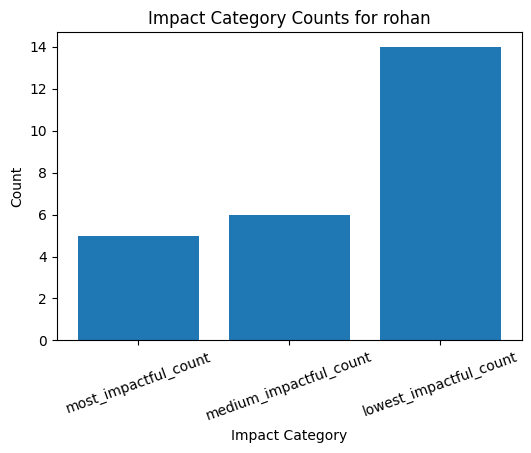

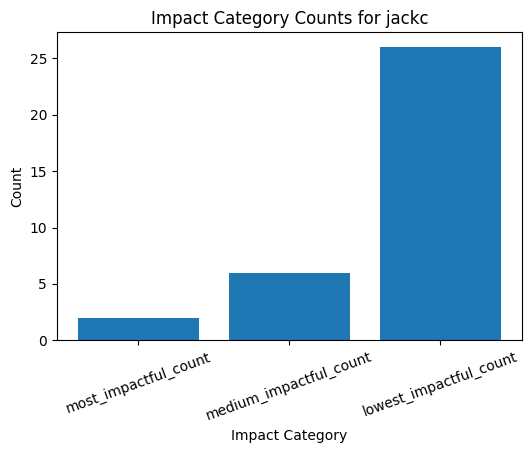

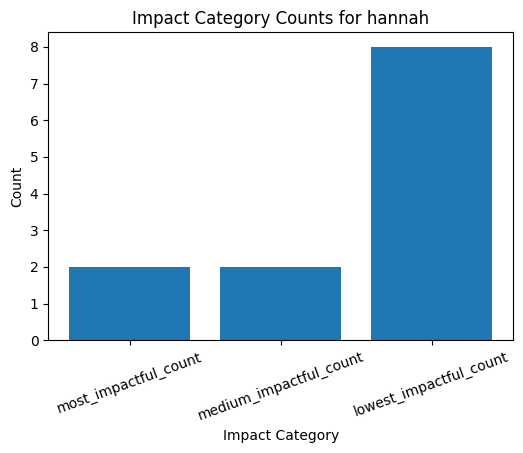

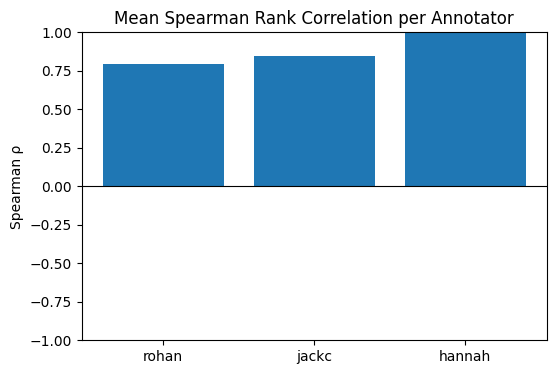

In [5]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# ---------------------------------------------------------
# Paths (update if needed)
# ---------------------------------------------------------
responses_dir = "/Users/hannahgonzalez/Documents/JHU/RankerWebsite/ranking-annotation-website-v2/server/responses"
payloads_dir = "/Users/hannahgonzalez/Documents/JHU/RankerWebsite/ranking-annotation-website-v2/src/payloads"

# ---------------------------------------------------------
# Find all task_2 annotation response files
# ---------------------------------------------------------
task2_files = [
    os.path.join(responses_dir, f)
    for f in os.listdir(responses_dir)
    if f.endswith("_responses_task_2.json")
]

print(f"Found {len(task2_files)} task_2 response files.\n")

records = []
category_counts = []
correlations = []

# ---------------------------------------------------------
# Process each annotator file
# ---------------------------------------------------------
for file_path in task2_files:
    base = os.path.basename(file_path)
    annotator = base.replace("_responses_task_2.json", "")

    # Load ground truth
    payload_file = os.path.join(payloads_dir, f"{annotator}-payload-task-2.json")
    if not os.path.exists(payload_file):
        print(f"⚠️ No payload found for {annotator}, skipping.")
        continue

    with open(payload_file, "r") as f:
        ground_data = json.load(f)

    # Build lookup: paperId → {candidateId: rank}
    ground_lookup = {
        entry["paperId"]: {c["paperId"]: int(c["rank"]) for c in entry["candidates"]}
        for entry in ground_data
    }

    # Load annotator responses
    with open(file_path, "r") as f:
        responses = json.load(f)

    # Category counters
    most = medium = lowest = 0

    # Spearman correlation accumulator
    all_spearman = []

    for entry in responses:
        paper_id = entry["paperId"]
        answers = entry["answer"]["answer"]
        ground_ranks_dict = ground_lookup.get(paper_id, {})

        # Count categories
        for cand, label in answers:
            if label == "most-impactful":
                most += 1
            elif label == "medium-impactful":
                medium += 1
            elif label == "lowest-impactful":
                lowest += 1

        # Ground truth rank sequence
        gt_ranks = []
        annotator_order = []
        for cand, _ in answers:
            if cand in ground_ranks_dict:
                gt_ranks.append(ground_ranks_dict[cand])
                annotator_order.append(cand)

        # Spearman correlation for this paper
        if len(gt_ranks) > 1:
            # Annotator’s implied ranking = answer list order
            annotator_rank_positions = list(range(1, len(annotator_order) + 1))
            rho, _ = spearmanr(annotator_rank_positions, gt_ranks)
            all_spearman.append(rho)

        # Sort answers by ground-truth rank
        ranked_pairs = [
            (ground_ranks_dict.get(cand), cand)
            for cand, _ in answers
            if ground_ranks_dict.get(cand) is not None
        ]
        ranked_pairs_sorted = sorted(ranked_pairs, key=lambda x: x[0])

        sorted_ids = [c for _, c in ranked_pairs_sorted]
        sorted_gt_ranks = [r for r, _ in ranked_pairs_sorted]

        records.append({
            "annotator": annotator,
            "paperId": paper_id,
            "answers": [c for c, _ in answers],
            "labels": [lbl for _, lbl in answers],
            "answers_sorted_by_ground": sorted_ids,
            "ground_truth_ranks_sorted": sorted_gt_ranks,
        })

    # Store category totals
    category_counts.append({
        "annotator": annotator,
        "most_impactful_count": most,
        "medium_impactful_count": medium,
        "lowest_impactful_count": lowest,
    })

    # Store mean Spearman correlation for this annotator
    correlations.append({
        "annotator": annotator,
        "mean_spearman": sum(all_spearman) / len(all_spearman) if all_spearman else None
    })

# ---------------------------------------------------------
# Build DataFrames
# ---------------------------------------------------------
df = pd.DataFrame(records)
df_counts = pd.DataFrame(category_counts)
df_corr = pd.DataFrame(correlations)

print("\n=== Category Counts per Annotator ===")
display(df_counts)

print("\n=== Spearman Rank Correlation per Annotator ===")
display(df_corr)

print("\n=== Detailed Comparison DataFrame ===")
display(df)

# ---------------------------------------------------------
# VISUALIZATIONS
# ---------------------------------------------------------

# --- Category distribution per annotator ---
for _, row in df_counts.iterrows():
    annotator = row["annotator"]
    counts = row[["most_impactful_count", "medium_impactful_count", "lowest_impactful_count"]]

    plt.figure(figsize=(6,4))
    plt.bar(counts.index, counts.values)
    plt.title(f"Impact Category Counts for {annotator}")
    plt.xlabel("Impact Category")
    plt.ylabel("Count")
    plt.xticks(rotation=20)
    plt.show()

# --- Spearman correlation bar plot ---
plt.figure(figsize=(6,4))
plt.bar(df_corr["annotator"], df_corr["mean_spearman"])
plt.title("Mean Spearman Rank Correlation per Annotator")
plt.ylabel("Spearman ρ")
plt.ylim(-1, 1)
plt.axhline(0, color="black", linewidth=0.8)
plt.show()


Found 3 task_2 response files.


=== Category Counts per Annotator ===


,annotator,most_impactful_count,medium_impactful_count,lowest_impactful_count
0,rohan,5,6,14
1,jackc,2,6,26
2,hannah,2,2,8



=== Spearman (single global ranking) per Annotator ===


,annotator,spearman_rho,spearman_pval,n_comparisons
0,rohan,0.795385,2.017352e-06,25
1,jackc,0.845989,2.979521e-10,34
2,hannah,0.993007,1.301673e-10,12



=== Detailed Comparison DataFrame (per paper entry) ===


,annotator,paperId,answers,labels,answers_sorted_by_ground,ground_truth_ranks_in_response_order
0,rohan,c43cc65148bf7221ff035c75621b663371fe8250,"[60b8ad6177230ad5402af409a6edb5af441baeb4, 9e3...","[most-impactful, most-impactful, most-impactfu...","[60b8ad6177230ad5402af409a6edb5af441baeb4, 590...","[1, 3, 5, 8, 6, 19, 11, 13, 2, 15, 4, 18, 7, 1..."
1,jackc,88833319309da6d8a8d7ab0318f72f6d6f383b30,"[28e3a79454bd09a2021a91e42b4b180477796445, 959...","[most-impactful, most-impactful, medium-impact...","[28e3a79454bd09a2021a91e42b4b180477796445, 959...","[1, 2, 12, 4, 34, 8, 5, 3, 6, 7, 9, 10, 11, 13..."
2,hannah,7b489c47ebca2c1df0e611e76b9649f69e4fce29,"[1bcd56b140a869fa8489cc6ed7e9088d13b2ffdd, 90a...","[most-impactful, most-impactful, medium-impact...","[90abbc2cf38462b954ae1b772fac9532e2ccd8b0, 1bc...","[2, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]"


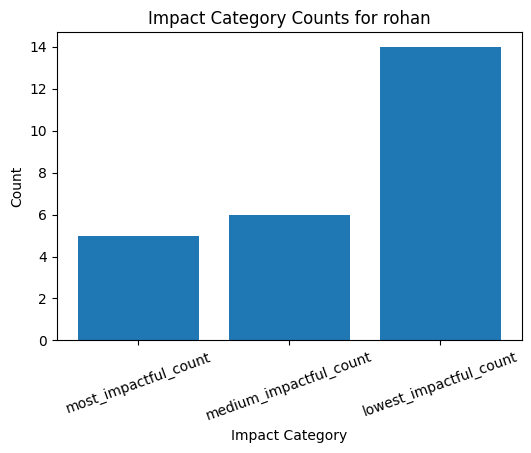

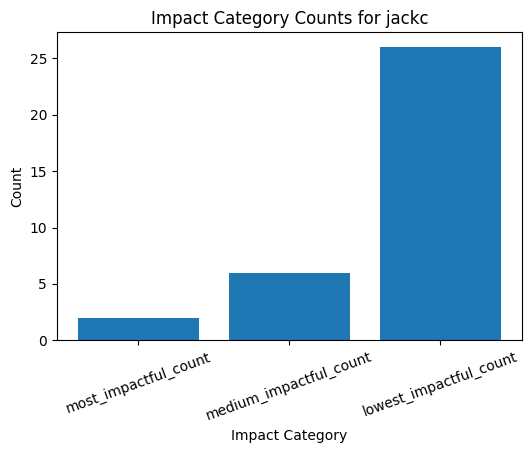

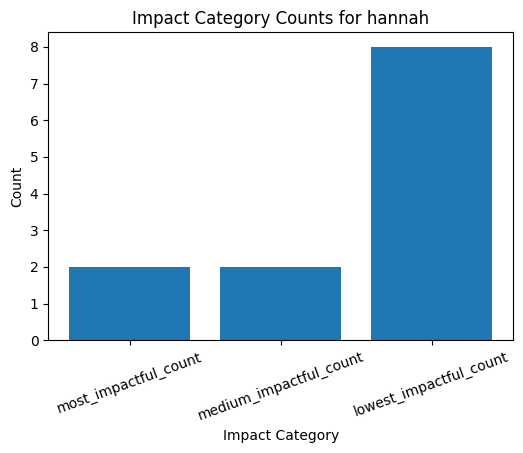

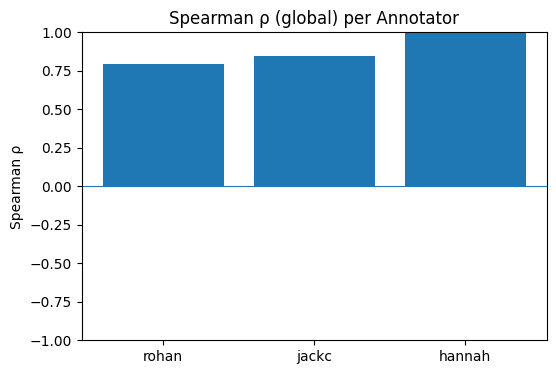


Spearman summary (raw values):
annotator  spearman_rho  spearman_pval  n_comparisons
    rohan      0.795385   2.017352e-06             25
    jackc      0.845989   2.979521e-10             34
   hannah      0.993007   1.301673e-10             12


In [7]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# ---------------------------------------------------------
# Paths (update if needed)
# ---------------------------------------------------------
responses_dir = "/Users/hannahgonzalez/Documents/JHU/RankerWebsite/ranking-annotation-website-v2/server/responses"
payloads_dir = "/Users/hannahgonzalez/Documents/JHU/RankerWebsite/ranking-annotation-website-v2/src/payloads"

# ---------------------------------------------------------
# Find all task_2 annotation response files
# ---------------------------------------------------------
task2_files = [
    os.path.join(responses_dir, f)
    for f in os.listdir(responses_dir)
    if f.endswith("_responses_task_2.json")
]

print(f"Found {len(task2_files)} task_2 response files.\n")

records = []
category_counts = []
spearman_results = []

# ---------------------------------------------------------
# Process each annotator file
# ---------------------------------------------------------
for file_path in task2_files:
    base = os.path.basename(file_path)
    annotator = base.replace("_responses_task_2.json", "")

    # Load ground truth payload for this annotator
    payload_file = os.path.join(payloads_dir, f"{annotator}-payload-task-2.json")
    if not os.path.exists(payload_file):
        print(f"⚠️ No payload found for {annotator}, skipping.")
        continue

    with open(payload_file, "r") as f:
        ground_data = json.load(f)

    # Build lookup: paperId -> {candidatePaperId: rank}
    ground_lookup = {
        entry["paperId"]: {c["paperId"]: int(c["rank"]) for c in entry["candidates"]}
        for entry in ground_data
    }

    # Load annotator responses
    with open(file_path, "r") as f:
        responses = json.load(f)

    # category counters
    most = medium = lowest = 0

    # For global Spearman: collect two parallel lists across ALL responses
    annotator_positions = []   # 1..N position in annotator-supplied order
    ground_ranks_for_positions = []  # corresponding ground-truth rank values

    position_counter = 0

    for entry in responses:
        paper_id = entry["paperId"]
        answers = entry["answer"]["answer"]  # list of [candidate_id, label]
        ground_ranks_dict = ground_lookup.get(paper_id, {})

        # Count categories
        for cand_id, label in answers:
            if label == "most-impactful":
                most += 1
            elif label == "medium-impactful":
                medium += 1
            elif label == "lowest-impactful":
                lowest += 1

        # Build ground-truth ranks in the same order as the annotator's answers
        gt_ranks_in_order = []
        annotator_ids_in_order = []
        for cand_id, label in answers:
            # Only include candidates that exist in ground truth for this paper
            if cand_id in ground_ranks_dict:
                gt_ranks_in_order.append(ground_ranks_dict[cand_id])
                annotator_ids_in_order.append(cand_id)
                position_counter += 1
                annotator_positions.append(position_counter)
                ground_ranks_for_positions.append(ground_ranks_dict[cand_id])
            else:
                # Candidate missing from ground truth: skip it (but you can log if desired)
                pass

        # Also compute a per-entry "answers_sorted_by_ground" if useful
        ranked_pairs = [
            (ground_ranks_dict.get(cand_id), cand_id)
            for cand_id, _ in answers
            if ground_ranks_dict.get(cand_id) is not None
        ]
        ranked_pairs_sorted = sorted(ranked_pairs, key=lambda x: x[0])
        sorted_ids = [c for _, c in ranked_pairs_sorted]

        # Record a row where ground_truth_ranks_in_response_order is the GT ranks
        records.append({
            "annotator": annotator,
            "paperId": paper_id,
            "answers": [c for c, _ in answers],
            "labels": [lbl for _, lbl in answers],
            "answers_sorted_by_ground": sorted_ids,
            "ground_truth_ranks_in_response_order": gt_ranks_in_order
        })

    # compute single Spearman correlation for the full concatenated list
    if len(annotator_positions) >= 2:
        rho, pval = spearmanr(annotator_positions, ground_ranks_for_positions)
    else:
        rho, pval = None, None

    spearman_results.append({
        "annotator": annotator,
        "spearman_rho": rho,
        "spearman_pval": pval,
        "n_comparisons": len(annotator_positions)
    })

    category_counts.append({
        "annotator": annotator,
        "most_impactful_count": most,
        "medium_impactful_count": medium,
        "lowest_impactful_count": lowest
    })

# ---------------------------------------------------------
# Build DataFrames and display
# ---------------------------------------------------------
df = pd.DataFrame(records)
df_counts = pd.DataFrame(category_counts)
df_spearman = pd.DataFrame(spearman_results)

print("\n=== Category Counts per Annotator ===")
display(df_counts)

print("\n=== Spearman (single global ranking) per Annotator ===")
display(df_spearman)

print("\n=== Detailed Comparison DataFrame (per paper entry) ===")
display(df)

# ---------------------------------------------------------
# VISUALIZATIONS
# ---------------------------------------------------------
# Category distribution per annotator
for _, row in df_counts.iterrows():
    annotator = row["annotator"]
    counts = row[["most_impactful_count", "medium_impactful_count", "lowest_impactful_count"]]

    plt.figure(figsize=(6,4))
    plt.bar(counts.index, counts.values)
    plt.title(f"Impact Category Counts for {annotator}")
    plt.xlabel("Impact Category")
    plt.ylabel("Count")
    plt.xticks(rotation=20)
    plt.show()

# Single Spearman bar (handles None)
plt.figure(figsize=(6,4))
x = df_spearman["annotator"]
y = df_spearman["spearman_rho"].fillna(0)  # fillna only for plotting; we show raw values below
plt.bar(x, y)
plt.title("Spearman ρ (global) per Annotator")
plt.ylabel("Spearman ρ")
plt.ylim(-1, 1)
plt.axhline(0, linewidth=0.8)
plt.show()

# Print Spearman numeric summary
print("\nSpearman summary (raw values):")
print(df_spearman.to_string(index=False))


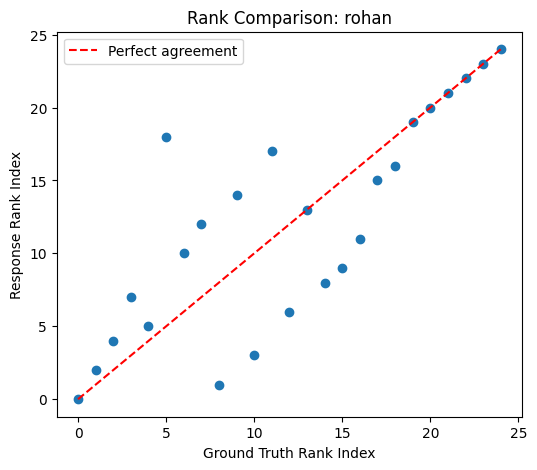

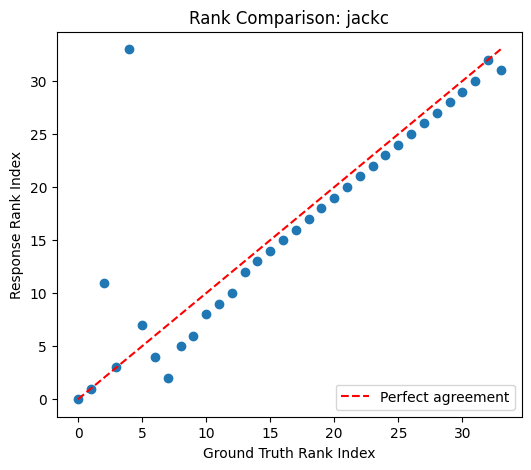

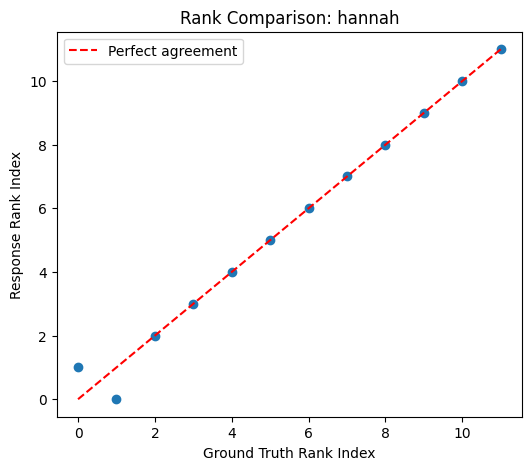

,annotator,spearman_corr,p_value
0,rohan,0.795385,2.017352e-06
1,jackc,0.845989,2.979521e-10
2,hannah,0.993007,1.301673e-10


In [20]:
import json
import os
import pandas as pd
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

# Paths
responses_folder = "/Users/hannahgonzalez/Documents/JHU/RankerWebsite/ranking-annotation-website-v2/server/responses/"
ground_truth_folder = "/Users/hannahgonzalez/Documents/JHU/RankerWebsite/ranking-annotation-website-v2/src/payloads/"

# List to store results
results = []

# Loop over all JSON files in the responses folder
for filename in os.listdir(responses_folder):
    if filename.endswith(".json"):
        annotator_name = filename.split("_")[0]  # e.g., "hannah"
        response_path = os.path.join(responses_folder, filename)
        payload_path = os.path.join(ground_truth_folder, filename.replace("_responses_task_2", "-payload-task-2"))  # match filename
        
        # Load response and payload
        with open(response_path, "r") as f:
            responses_data = json.load(f)
        with open(payload_path, "r") as f:
            ground_truth_data = json.load(f)
        
        # Extract paperIds
        response_paper_ids = [item[0] for item in responses_data[0]["answer"]["answer"]]
        ground_truth_paper_ids = [candidate["paperId"] for candidate in sorted(ground_truth_data[0]["candidates"], key=lambda x: x["rank"])]
        
        # Map response IDs to ground truth indices
        ground_truth_index_map = {pid: i for i, pid in enumerate(ground_truth_paper_ids)}
        response_indices_in_gt = [ground_truth_index_map[pid] for pid in response_paper_ids]
        ground_truth_indices = list(range(len(ground_truth_paper_ids)))
        
        # Compute Spearman correlation
        corr, p_value = spearmanr(ground_truth_indices, response_indices_in_gt)
        
        # Save results to list
        results.append({
            "annotator": annotator_name,
            "spearman_corr": corr,
            "p_value": p_value
        })
        
        # Optional: plot for each annotator
        plt.figure(figsize=(6,5))
        plt.scatter(ground_truth_indices, response_indices_in_gt)
        plt.plot([0, len(ground_truth_indices)-1], [0, len(ground_truth_indices)-1], 'r--', label="Perfect agreement")
        plt.xlabel("Ground Truth Rank Index")
        plt.ylabel("Response Rank Index")
        plt.title(f"Rank Comparison: {annotator_name}")
        plt.legend()
        plt.show()

# Convert results to DataFrame
df_results = pd.DataFrame(results)
df_results


  annotator  spearman_corr
0     rohan       0.795385
1     jackc       0.845989
2    hannah       0.993007


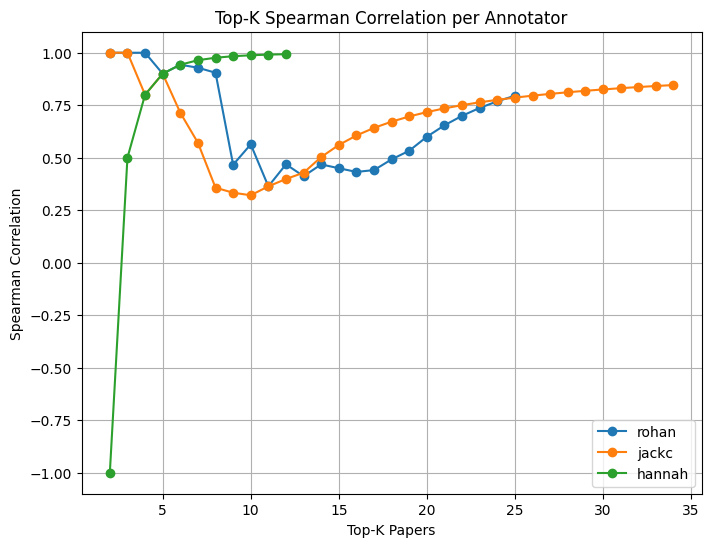

In [21]:
import json
import os
import pandas as pd
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

# Paths
responses_folder = "/Users/hannahgonzalez/Documents/JHU/RankerWebsite/ranking-annotation-website-v2/server/responses/"
ground_truth_folder = "/Users/hannahgonzalez/Documents/JHU/RankerWebsite/ranking-annotation-website-v2/src/payloads/"

# Store results
annotator_results = {}
topk_corr = {}

# Loop over all JSON files in the responses folder
for filename in os.listdir(responses_folder):
    if filename.endswith(".json"):
        annotator_name = filename.split("_")[0]  # e.g., "hannah"
        response_path = os.path.join(responses_folder, filename)
        payload_path = os.path.join(ground_truth_folder, filename.replace("_responses_task_2", "-payload-task-2"))  # match filename
        
        # Load JSONs
        with open(response_path, "r") as f:
            responses_data = json.load(f)
        with open(payload_path, "r") as f:
            ground_truth_data = json.load(f)
        
        # Extract paperIds
        response_paper_ids = [item[0] for item in responses_data[0]["answer"]["answer"]]
        ground_truth_paper_ids = [candidate["paperId"] for candidate in sorted(ground_truth_data[0]["candidates"], key=lambda x: x["rank"])]
        
        # Map response IDs to ground truth indices
        ground_truth_index_map = {pid: i for i, pid in enumerate(ground_truth_paper_ids)}
        response_indices_in_gt = [ground_truth_index_map[pid] for pid in response_paper_ids]
        ground_truth_indices = list(range(len(ground_truth_paper_ids)))
        
        # Compute full Spearman correlation
        corr, p_value = spearmanr(ground_truth_indices, response_indices_in_gt)
        annotator_results[annotator_name] = corr
        
        # Compute top-k Spearman correlations
        topk_corr[annotator_name] = []
        N = len(ground_truth_paper_ids)
        for k in range(1, N+1):
            corr_k, _ = spearmanr(ground_truth_indices[:k], response_indices_in_gt[:k])
            topk_corr[annotator_name].append(corr_k)

# Convert full Spearman correlations to DataFrame
df_results = pd.DataFrame({
    "annotator": list(annotator_results.keys()),
    "spearman_corr": list(annotator_results.values())
})
print(df_results)

# Plot top-k Spearman correlations
plt.figure(figsize=(8,6))
for annotator, corr_list in topk_corr.items():
    plt.plot(range(1, len(corr_list)+1), corr_list, marker='o', label=annotator)
plt.xlabel("Top-K Papers")
plt.ylabel("Spearman Correlation")
plt.title("Top-K Spearman Correlation per Annotator")
plt.legend()
plt.grid(True)
plt.show()
